In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn
seaborn.set()

In [2]:
airbnb = pd.read_csv('listings.csv')
airbnb = airbnb.rename(columns={"latitude": "lat", "longitude": "lon"})

In [3]:
amenities = pd.read_json('osm/amenities-vancouver.json.gz', lines=True)
# amenities = pd.read_csv('interesting_amenities.csv')
# amenities

In [4]:
def distance_count(airbnb, amenities):
    lat1 = airbnb['lat']
    lat2 = amenities['lat']
    lon1 = airbnb['lon']
    lon2 = amenities['lon']
    p = np.pi/180
    b = np.cos((lat2.sub(lat1)).mul(p)).div(2) #series
    c = np.cos(lat1*p) #number
    d = np.cos(lat2.mul(p)) #series
    e = np.subtract(1,np.cos((lon2.sub(lon1)).mul(p))).div(2) #series
    a = np.subtract(0.5, b).add((d.mul(c)).mul(e))
    
    distances = np.arcsin(np.sqrt(a)).mul(12742)
    
    threshold = 0.1
    nearby_distances = distances[distances < threshold]
    count = len(nearby_distances.index)
#     print(count)
    return count
# https://stackoverflow.com/a/21623206

In [5]:
airbnb['num_amenities'] = airbnb.apply(lambda x: distance_count(x, amenities), axis=1)
# airbnb['num_amenities']

In [6]:
rpm_ame = airbnb[['reviews_per_month', 'num_amenities']]
# rpm_ame

In [7]:
rpm_ame =  rpm_ame.dropna()
# rpm_ame

In [8]:
fit = stats.linregress(rpm_ame['num_amenities'],rpm_ame['reviews_per_month'] )

In [9]:
fit.slope, fit.intercept

(0.005014368875876933, 1.4039141120444443)

In [10]:
rpm_ame['prediction'] = rpm_ame['num_amenities']*fit.slope + fit.intercept

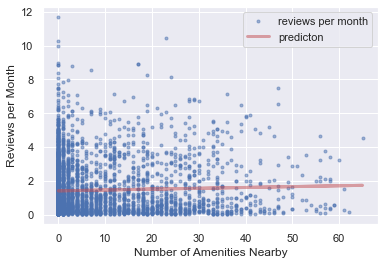

In [34]:
plt.plot(rpm_ame['num_amenities'], rpm_ame['reviews_per_month'], 'b.', linewidth=3, alpha=0.5, label='reviews per month')
plt.plot(rpm_ame['num_amenities'], rpm_ame['prediction'], 'r-', linewidth=3, alpha=0.5, label='predicton')
plt.xlabel('Number of Amenities Nearby')
plt.ylabel('Reviews per Month')
plt.legend(loc="upper right")
plt.show()

In [12]:
print(fit.pvalue)

0.015615801474230716


In [13]:
residuals = rpm_ame['reviews_per_month'] - (fit.slope * rpm_ame['num_amenities']) + fit.intercept
# residuals

In [14]:
rpm_ame['has_amenities'] = (rpm_ame['num_amenities'] > 0)

In [15]:
rpm_ame

,reviews_per_month,num_amenities,prediction,has_amenities
0,0.15,15,1.479130,True
1,3.40,20,1.504201,True
2,0.76,1,1.408928,True
3,0.27,0,1.403914,False
4,0.19,0,1.403914,False
...,...,...,...,...
4701,2.00,45,1.629561,True
4705,3.00,10,1.454058,True
4708,2.00,56,1.684719,True
4725,1.00,0,1.403914,False


In [16]:
has_amenities = rpm_ame[rpm_ame['has_amenities'] == True]
# has_amenities

In [17]:
no_amenities = rpm_ame[rpm_ame['has_amenities'] == False]

In [18]:
stats.mannwhitneyu(has_amenities['reviews_per_month'], no_amenities['reviews_per_month'], alternative="two-sided")

MannwhitneyuResult(statistic=1825212.0, pvalue=0.0583919097866064)

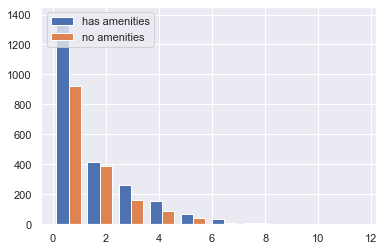

In [28]:
plt.hist([(has_amenities['reviews_per_month']), (no_amenities['reviews_per_month'])], label=['has amenities','no amenities'])
plt.legend(loc="upper left")

In [31]:
np.mean(has_amenities['reviews_per_month'])

1.4479725675096464

In [32]:
np.mean(no_amenities['reviews_per_month'])

1.4329901356350176

(array([ 10.,  51., 109., 192., 299., 358., 437., 410., 385.,  82.]),
 array([-4.60517019, -3.91018454, -3.21519889, -2.52021325, -1.8252276 ,
        -1.13024196, -0.43525631,  0.25972933,  0.95471498,  1.64970062,
         2.34468627]),
 <a list of 10 Patch objects>)

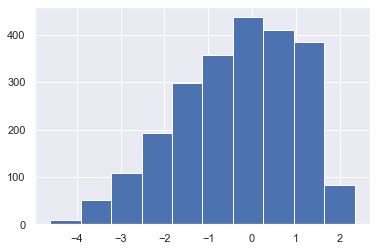

In [19]:
plt.hist(np.log(has_amenities['reviews_per_month']))

(array([  7.,  16.,  61., 127., 202., 223., 367., 386., 210.,  23.]),
 array([-4.60517019, -3.89852349, -3.19187679, -2.48523009, -1.7785834 ,
        -1.0719367 , -0.36529   ,  0.34135669,  1.04800339,  1.75465009,
         2.46129678]),
 <a list of 10 Patch objects>)

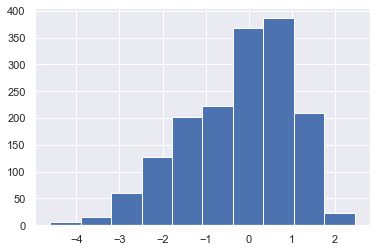

In [20]:
plt.hist(np.log(no_amenities['reviews_per_month']))

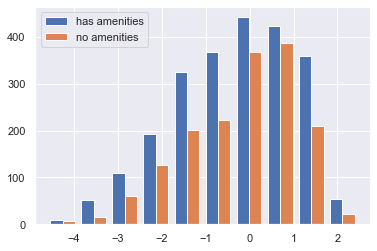

In [21]:
plt.hist([np.log(has_amenities['reviews_per_month']), np.log(no_amenities['reviews_per_month'])], label=['has amenities','no amenities'])
plt.legend(loc="upper left")

In [22]:
ttest = stats.ttest_ind(np.log(has_amenities['reviews_per_month']), np.log(no_amenities['reviews_per_month']))

In [23]:
ttest.pvalue

0.02029359842645871

In [24]:
rpm_ame['rpy_over_1'] = (rpm_ame['reviews_per_month']*12 >= 1)

In [25]:
ct = pd.crosstab(rpm_ame['has_amenities'], rpm_ame['rpy_over_1'])
ct

rpy_over_1,False,True
has_amenities,,
False,84,1538
True,170,2163


In [26]:
chi2, p, dof, expected = stats.chi2_contingency(ct)

In [27]:
p

0.009491488397988398